In [2]:
import torch
import torchio as tio

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, segmentation, morphology, measure, transform

from skimage import feature
import cv2 as cv
import scipy.signal as signal

from ipywidgets import interact
import ipywidgets as widgets

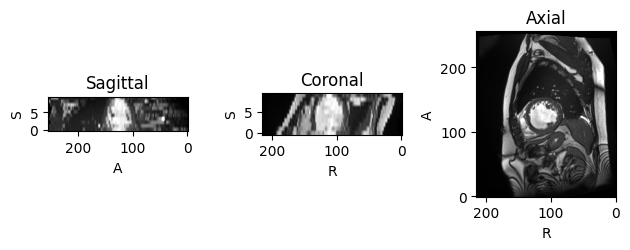

In [3]:
patient_1 = tio.Subject(
    t1=tio.ScalarImage('database/training/patient001/patient001_4d.nii.gz'),
    im1=tio.ScalarImage('database/training/patient001/patient001_frame01.nii.gz'),
    label1=tio.LabelMap('database/training/patient001/patient001_frame01_gt.nii.gz'),
    im2=tio.ScalarImage('database/training/patient001/patient001_frame12.nii.gz'),
    label2=tio.LabelMap('database/training/patient001/patient001_frame12_gt.nii.gz'),
)
# patient_1.im1.plot()
# patient_1.label1.plot()

patient_1.t1.shape
patient_1.t1.plot()

test de transformation mais on ne va pour le moment pas l'utiliser

In [4]:
# On va essayer de faire une transformation de l'image

rescale = tio.RescaleIntensity(out_min_max=(0,1))
spatial = tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    },
    p=0.75,
)

transforms = [rescale, spatial]
transform = tio.Compose(transforms)
transformed = transform(patient_1)
# transformed.im1.plot()

### Détermination de la seed !

On va essayer d'implémenter le papier de Khened, et pour chaque image de trouver une seed situé à peu près au milieu du ventricule gauche.

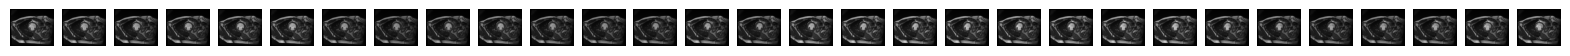

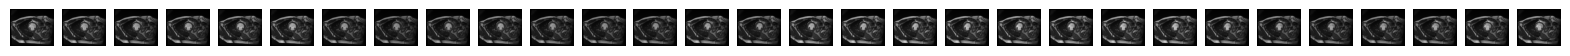

In [26]:
# On commence par load l'image d'un patient

patient = tio.Subject(
    t1=tio.ScalarImage('database/training/patient001/patient001_4d.nii.gz'),
    im1=tio.ScalarImage('database/training/patient001/patient001_frame01.nii.gz'),
    label1=tio.LabelMap('database/training/patient001/patient001_frame01_gt.nii.gz'),
    im2=tio.ScalarImage('database/training/patient001/patient001_frame12.nii.gz'),
    label2=tio.LabelMap('database/training/patient001/patient001_frame12_gt.nii.gz'),
)

data = patient.t1.data

fig1,ax1 = plt.subplots(1,30, figsize=(20, 4))
for i in range(30):
    ax1[i].imshow(data[i,:,:,5], cmap='gray')
    ax1[i].axis('off')
fig2, ax2 = plt.subplots(1,30, figsize=(20, 4))
for i in range(30):
    ax2[i].imshow(data[i,:,:,5], cmap='gray')
    ax2[i].axis('off')

Ici on affiche une tranche, qui évolue avec le temps.On a pour chaque image :
$$data[tranche,x,y,temps]$$
On voit très nettement la compression décompression du ventricule gauche. C'est ce mouvement qu'on va essayer d'aller chercher.

Pour cela faisont une TF, on devrait voir un pic au niveau de notre point d'interet.

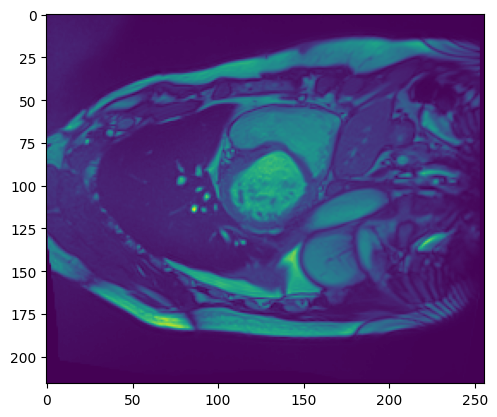

In [6]:
plt.imshow(data[0,:,:,1])

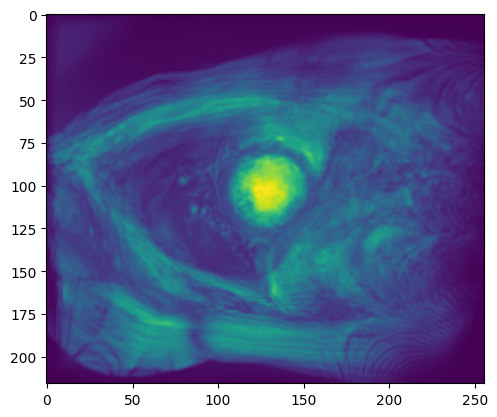

In [40]:
# On calcule la TF
tf = np.fft.fftn(data[0,:,:,:], axes=[2])
mag = np.abs(tf)
plt.imshow(mag[:,:,0])

# On va conserver la composante de Hilbert :
pre_image = mag[:,:,0]

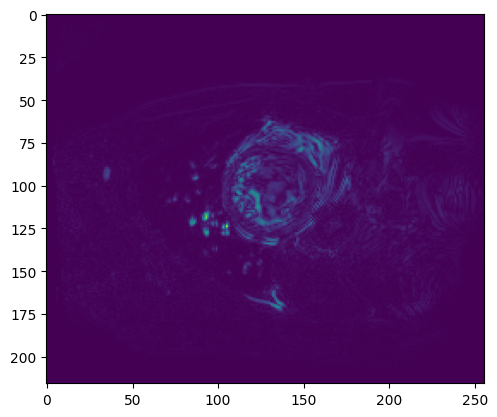

In [41]:
# On calcule la TF
tf = np.fft.fftn(data[:,:,:,5], axes=[0])
mag = np.abs(tf)
plt.imshow(mag[2,:,:])

# On va conserver la composante de Hilbert :
pre_image_2 = mag[:,:,0]

In [8]:
# Que se passe t'il si on fait un seuillage ? Ou un filtrage ?

# 1. Seuillage
threshold = filters.threshold_otsu(pre_image)
test = pre_image > threshold
# plt.imshow(test)

def image_seuillee(image, tresh=0):
    if tresh == 0:
        tresh = filters.threshold_otsu(image)
    im_seuil = image > tresh
    return im_seuil

# On veut pouvoir régler le seuil de manière dynamique
# On va donc utiliser un slider
def interact_seuil(threshold):
    img_seuil = pre_image > threshold
    plt.imshow(img_seuil)

interact(interact_seuil, threshold=widgets.IntSlider(min=1000, max=2500, step=10, value=2000))

img_seuil = pre_image > 1850

interactive(children=(IntSlider(value=2000, description='threshold', max=2500, min=1000, step=10), Output()), …

(Text(0.5, 1.0, 'Gradient Y Sobel'), ([], []), ([], []))

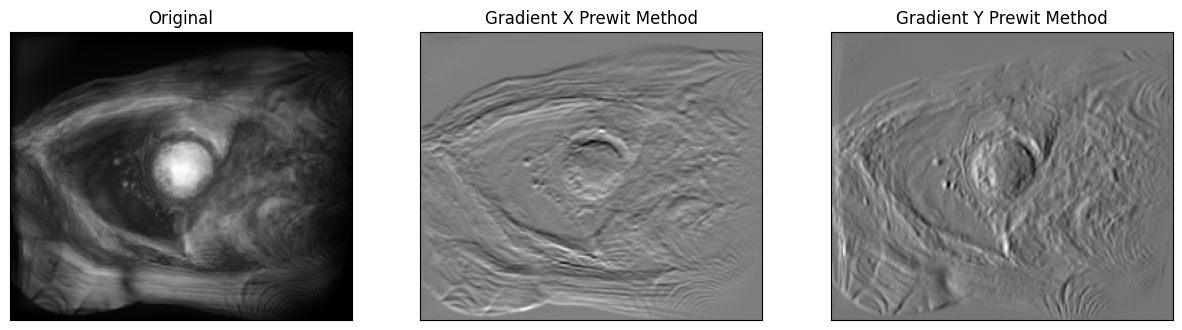

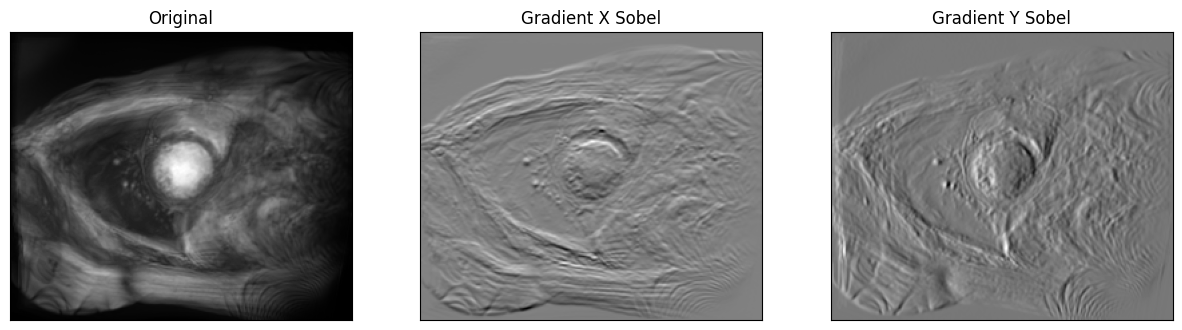

In [9]:
# 2. Gradient detection

kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

gradx = cv.filter2D(pre_image,-1,kernelx)
grady = cv.filter2D(pre_image,-1,kernely)

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1),plt.imshow(pre_image,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(gradx,cmap = 'gray')
plt.title('Gradient X Prewit Method'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(grady,cmap = 'gray')
plt.title('Gradient Y Prewit Method'), plt.xticks([]), plt.yticks([])

sobelx = cv.Sobel(pre_image,cv.CV_64F,0,1)
sobely = cv.Sobel(pre_image,cv.CV_64F,1,0)

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1),plt.imshow(pre_image,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(sobelx,cmap = 'gray')
plt.title('Gradient X Sobel'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(sobely,cmap = 'gray')
plt.title('Gradient Y Sobel'), plt.xticks([]), plt.yticks([])



(216, 256)
uint8


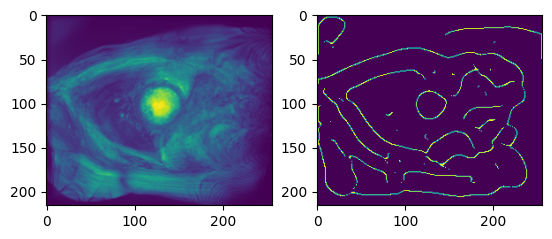

In [10]:
edges_float = feature.canny(pre_image, sigma=8)
edges = (edges_float*255).astype(np.uint8)

plt.subplot(121)
plt.imshow(pre_image)
plt.subplot(122)
plt.imshow(edges)

print(edges.shape)
print(edges.dtype)

In [11]:
def grayscale(image):
    return np.dot(image[:,:,:3], [0.2989, 0.5870, 0.1140])

In [12]:
import cv2 as cv

pre_hough = img_seuil.astype(np.uint8)

# plt.imshow(pre_hough)
print(pre_hough.shape)

if pre_hough is None:
    print("Error loading")
    exit(-1)
else : 
    pre_hough.dtype
    grey_blur = cv.GaussianBlur(edges,(5,5),2)
    grey_blur_norm = cv.normalize(edges, dst=None, alpha=0,beta=255,norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
    # plt.imshow(pre_hough)
    # plt.imshow(edges)
    circles=cv.HoughCircles(edges,cv.HOUGH_GRADIENT, dp=1,minDist=10, param1=151, param2=29, minRadius=0, maxRadius=0)

# HoughCircles
if circles is None:
    print("problemeeeeee")
else:
    print("ok !")


(216, 256)
ok !


In [13]:
def plot_circles(image,circles):
    out = image.copy()
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x,y,r) in circles:
            print(f"(x,y) = ({x},{y}) de rayon {r}")
            cv.circle(out,(x,y),r,(255,0,0),1)
            cv.line(out,(x-2,y-2),(x+2,y+2),(0,128,255),1)
            cv.line(out,(x+2,y-2),(x-2,y+2),(0,128,255),1)
        # tout sera cramé car en saturation, on va donc normaliser sur 0-255/2
        # image = cv.normalize(image, dst=None, alpha=0,beta=255//2,norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
        out = cv.normalize(out, dst=None, alpha=0,beta=255,norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
        # plt.imshow(np.hstack([image,out]))
        plt.imshow(out)

In [14]:
def tf_mag(image):
    # On calcule la TF
    tf = np.fft.fftn(image[0,:,:,:], axes=[2])
    mag = np.abs(tf)
    # On va conserver la composante de Hilbert :
    pre_image = mag[:,:,0]
    return pre_image

In [44]:
def traitement_hough(image, param1=150, param2=40):
    if image is None:
        print("Error loading image")
        exit(-1)
    else : 
        # print(f"Le type de l'image est {image.dtype}")
        grey_blur = cv.GaussianBlur(image,(5,5),2)
        grey_blur_norm = cv.normalize(grey_blur, dst=None, alpha=0,beta=255,norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
        plt.imshow(grey_blur_norm)
        # plt.imshow(edges)
        circles=cv.HoughCircles(grey_blur_norm,cv.HOUGH_GRADIENT, dp=1,minDist=20, param1=150, param2=40, minRadius=1, maxRadius=40)

    # HoughCircles
    return circles

In [16]:
def canny(image,sigma=5):
    edges_float = feature.canny(image,sigma)
    edges = (edges_float*255).astype(np.uint8)
    return edges

(x,y) = (128,100) de rayon 16


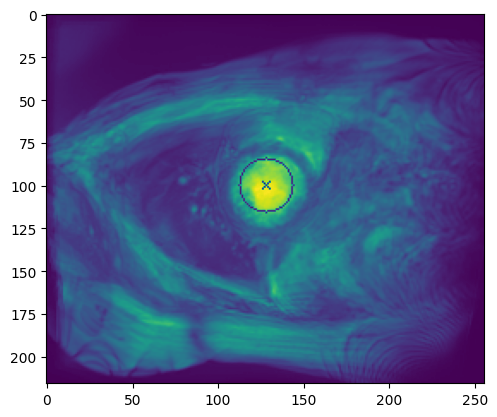

In [17]:
im_entree = patient.t1.data
im_tf = tf_mag(im_entree)
im_canny = canny(im_tf, sigma=9)
circles = traitement_hough(im_canny)
plot_circles(im_tf, circles)

(x,y) = (130,102) de rayon 19


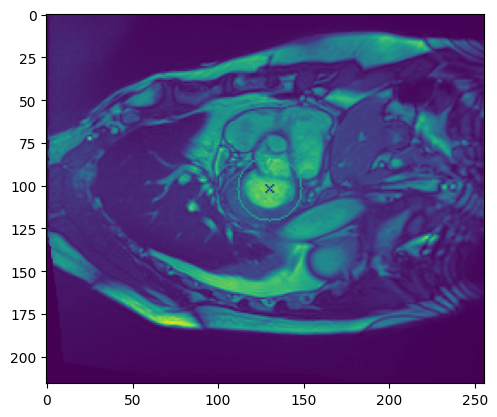

In [18]:
# On teste la meme chose avec la méthode de seuillage
im_seuil = image_seuillee(im_tf, 1850)
im_seuil_canny = canny(im_seuil, sigma=9)
circles_seuil = traitement_hough(im_seuil_canny)

torch_affichage = im_entree[0,:,:,0]
im_affichage = torch_affichage.numpy()
# print(im_affichage.shape)
plot_circles(im_affichage, circles_seuil)

on va maintenant tester notre approche sur l'ensemble des patients du dataset, et sauvegarder chaque image dans un dossier test

In [19]:
# on va maintenant tester notre approche sur l'ensemble des patients du dataset, et sauvegarder chaque image dans un dossier test

def recherche_cercles_dataset(nb):
    reussite = 0
    for i in range (1,nb):
        patient = tio.Subject(
            t1=tio.ScalarImage(f'database/training/patient{i:03d}/patient{i:03d}_4d.nii.gz'),
        )
        im_entree = patient.t1.data
        im_tf = tf_mag(im_entree)
        im_canny = canny(im_tf, sigma=9)
        circles = traitement_hough(im_canny)
        if circles is None:
            print(f"Patient {i:03d} : Pas de cercles trouvés")
        else:
            reussite +=1
            plot_circles(im_tf, circles)
        plt.savefig(f"test/patient{i:03d}.png")
    print(f"Nombre de patients avec succès : {reussite}/{i}")

(x,y) = (128,100) de rayon 16
(x,y) = (126,106) de rayon 17
Nombre de patients avec succès : 2/2


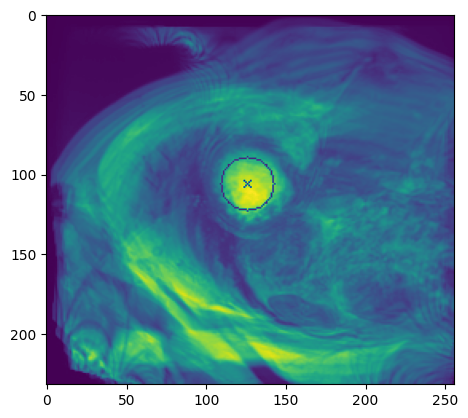

In [43]:
recherche_cercles_dataset(3)

### Problème : patient 4 
Je ne comprend pas pourquoi le patient 4 on ne trouve pas le cercle ... il est clairement visible sur le canny, on prend des paramètres tellement large que pour d'autres patients ils mènent à la découverte de dizaines de cercles ... et pour celui ci : RIEN

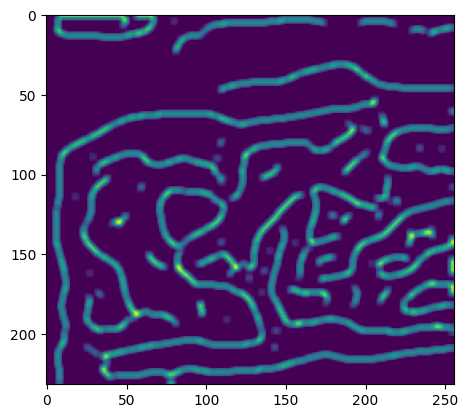

In [21]:
patient_4 = tio.Subject(
    t1=tio.ScalarImage('database/training/patient004/patient004_4d.nii.gz'),
)
data = patient_4.t1.data
im_tf = tf_mag(data)
im_canny = canny(im_tf, sigma=6)
circles = traitement_hough(im_canny, param1=60, param2=10)
plot_circles(im_canny, circles)

On voit qu'on trouve des cercles, mais qu'on rate quand meme beaucoup d'images ...
Pour cela on pourrait :
1. si la méthode classique échoue, on tente un seuillage
2. faire une recherche itérative d'un seul cercle. C'est à dire qu'on part d'un paramètre élevé pour Hough, puis on diminue jusqu'a obtenir un seul cercle.

Pourtant, le patient 4 met un doute sur l'approche numéro 2 ...

Essayons donc la première

In [22]:
def recherche_cercles_dataset_upgrade(nb):
    reussite = 0
    for i in range (1,nb):
        patient = tio.Subject(
            t1=tio.ScalarImage(f'database/training/patient{i:03d}/patient{i:03d}_4d.nii.gz'),
        )
        im_entree = patient.t1.data
        im_tf = tf_mag(im_entree)
        im_seuillee = image_seuillee(im_tf, 1600)
        # Dans un premier temps, on tente l'approche classique par canny sur la tf
        im_canny = canny(im_tf, sigma=9)
        circles = traitement_hough(im_canny)
        if circles is None:
            im_canny_2 = canny(im_seuillee, sigma=9)
            circles = traitement_hough(im_canny_2)
            if circles is None:
                print(f"Patient {i:03d} : Pas de cercles trouvés")
            else:
                reussite +=1
                plot_circles(im_tf, circles)
        else:
            reussite +=1
            plot_circles(im_tf, circles)
        plt.savefig(f"test/patient{i:03d}.png")
    print(f"Nombre de patients avec succès : {reussite}/{i}")

(x,y) = (128,100) de rayon 16
(x,y) = (126,106) de rayon 17
(x,y) = (132,116) de rayon 16
Patient 004 : Pas de cercles trouvés
(x,y) = (92,106) de rayon 17
(x,y) = (128,112) de rayon 18
Patient 007 : Pas de cercles trouvés
Patient 008 : Pas de cercles trouvés
(x,y) = (136,98) de rayon 17
Patient 010 : Pas de cercles trouvés
(x,y) = (116,88) de rayon 16
(x,y) = (134,86) de rayon 15
Patient 013 : Pas de cercles trouvés
(x,y) = (92,118) de rayon 22
(x,y) = (92,140) de rayon 17
Patient 016 : Pas de cercles trouvés
Patient 017 : Pas de cercles trouvés
Patient 018 : Pas de cercles trouvés
(x,y) = (132,100) de rayon 20
Patient 020 : Pas de cercles trouvés
Patient 021 : Pas de cercles trouvés
(x,y) = (118,92) de rayon 22
(x,y) = (122,98) de rayon 12
Patient 024 : Pas de cercles trouvés
(x,y) = (120,124) de rayon 15
(x,y) = (134,100) de rayon 13
(x,y) = (132,96) de rayon 16
Patient 028 : Pas de cercles trouvés
(x,y) = (140,86) de rayon 14
Patient 030 : Pas de cercles trouvés
(x,y) = (124,106) d

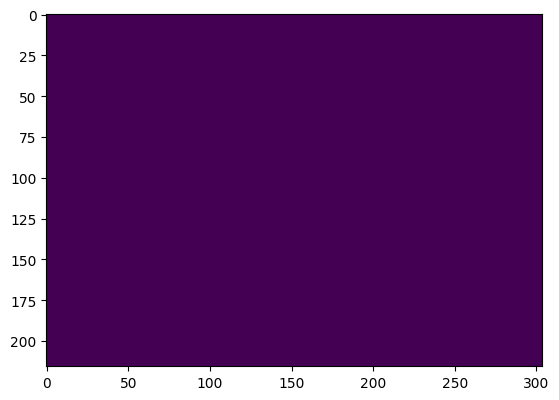

In [23]:
recherche_cercles_dataset_upgrade(101)

# 2 patients en plus ... pas dinguo